In [ ]:
import napari
from movement.filtering import filter_by_confidence, interpolate_over_time

from movement_napari.layer_styles import TracksStyle, PointsStyle
from movement_napari.utils import columns_to_categorical_codes
from movement_napari.convert import ds_to_napari_tracks
from movement.io.load_poses import from_file
from napari_video.napari_video import VideoReaderNP
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np

## Data Overview

In [2]:
data_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\sample_video_for_triangulation\multicam_video_2024-07-24T10_04_55_cropped_20241104101620")
video_path = data_path / "multicam_video_2024-07-24T10_04_55_mirror-bottom.avi.mp4"
slp_inference_path = next(video_path.parent.glob(f"{video_path.stem}*.slp"))  # data_path / "multicam_video_2024-07-24T10_04_55_cropped_20241104101620.slp"
dlc_inference_path = next(video_path.parent.glob(f"{video_path.stem}*.h5"))  # data_path / "multicam_video_2024-07-24T10_04_55_central.aviDLC_resnet50_labels.v001.pkg_converted2024-11-21shuffle1_50000.h5"

ds_sleap = from_file(slp_inference_path, source_software="SLEAP")
ds_dlc = from_file(dlc_inference_path, source_software="DeepLabCut")

In [12]:
ds_dlc.info

<bound method Dataset.info of <xarray.Dataset> Size: 11MB
Dimensions:      (time: 35966, individuals: 1, keypoints: 13, space: 2)
Coordinates:
  * time         (time) int32 144kB 0 1 2 3 4 ... 35961 35962 35963 35964 35965
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U12 624B 'nose' 'Lear' ... 'UpperMid' 'UpperBack'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 7MB 287.9 ... ...
    confidence   (time, individuals, keypoints) float64 4MB 1.0 ... 0.9866
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  DeepLabCut
    source_file:      D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/t...
    ds_type:          poses>

### Plot distance overtime coloured by confidence

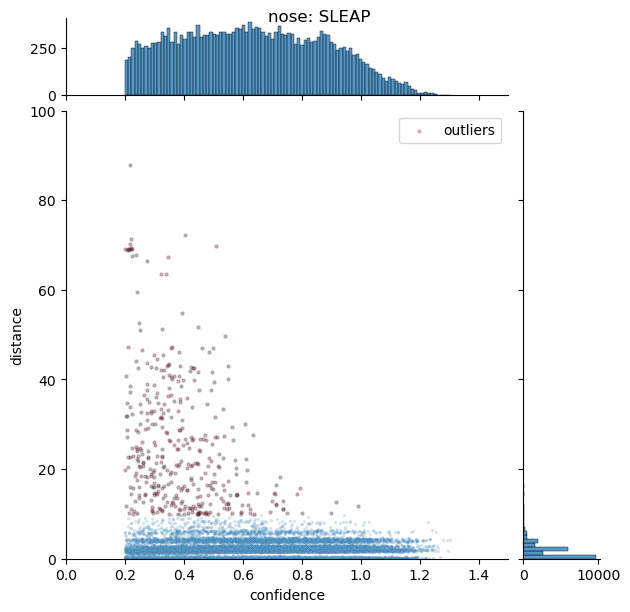

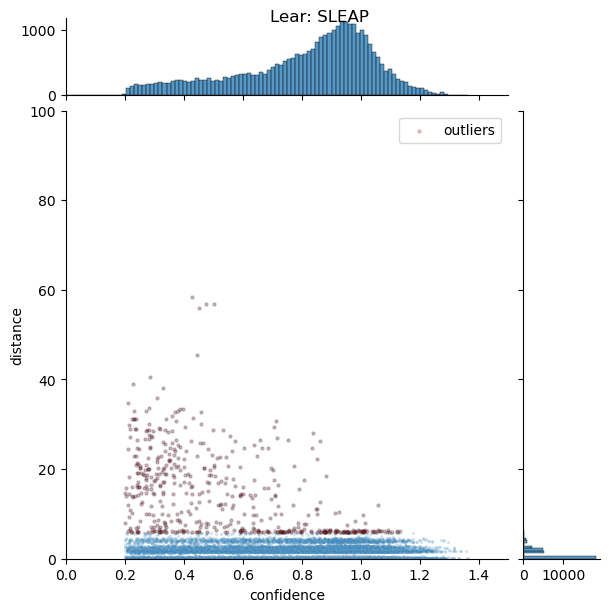

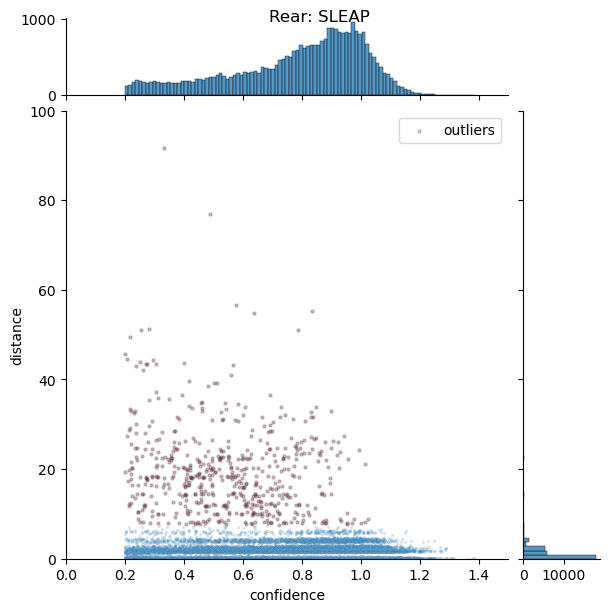

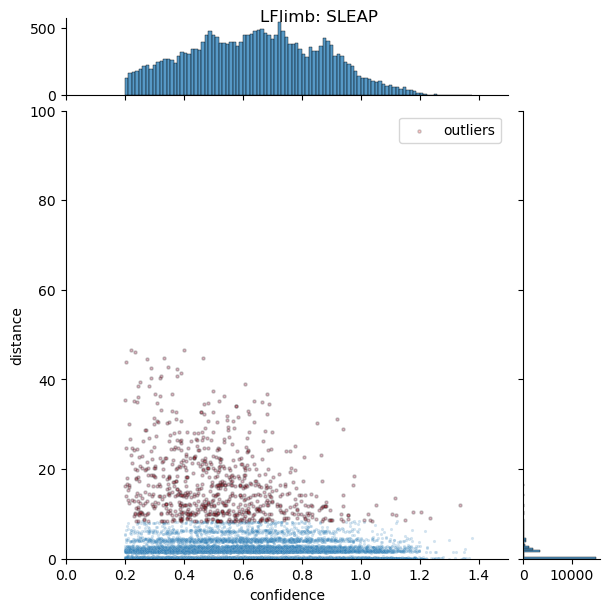

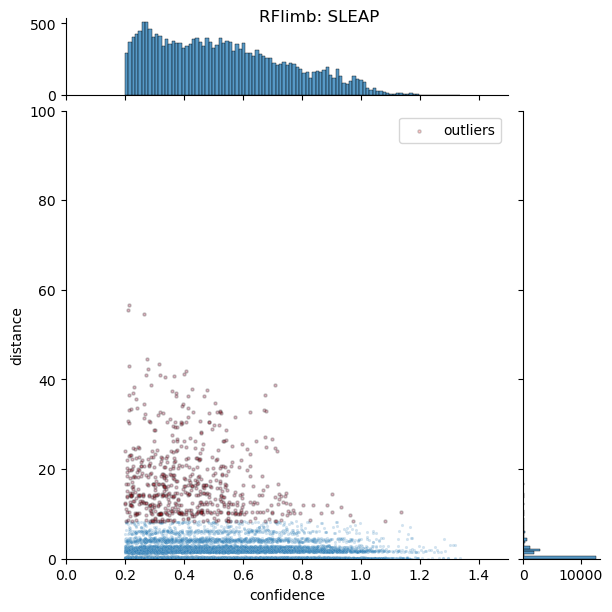

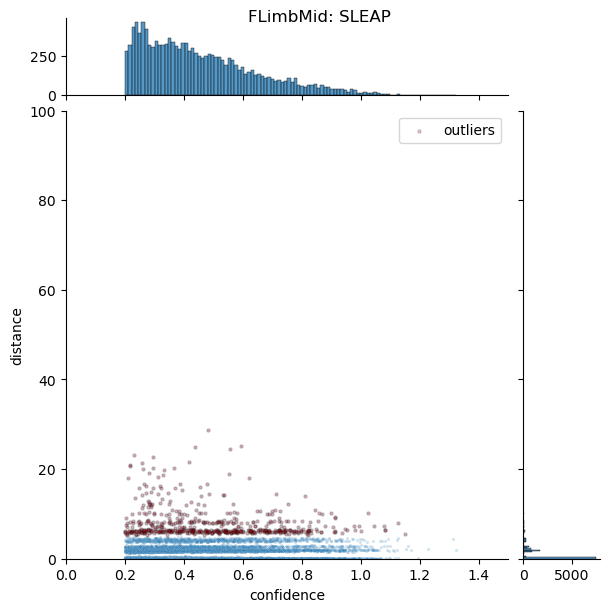

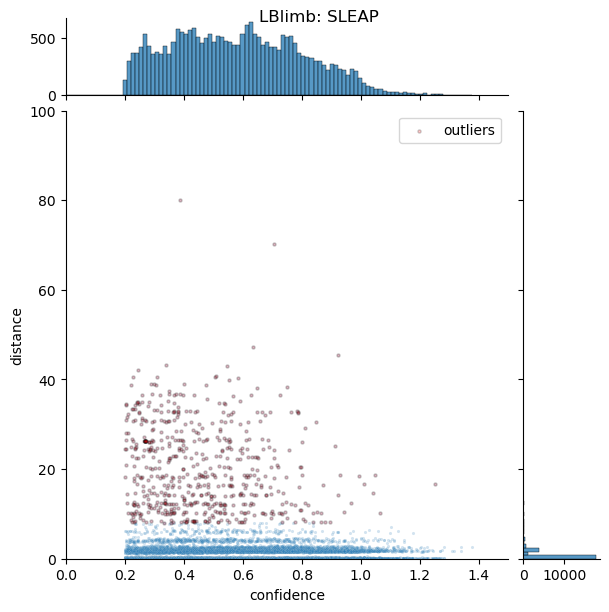

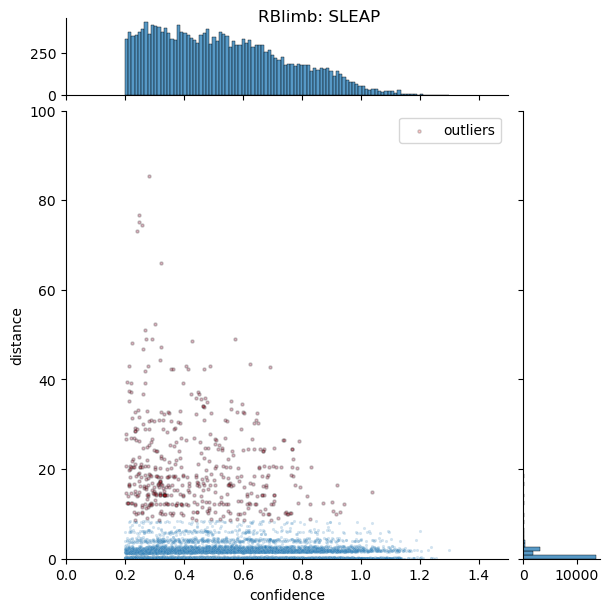

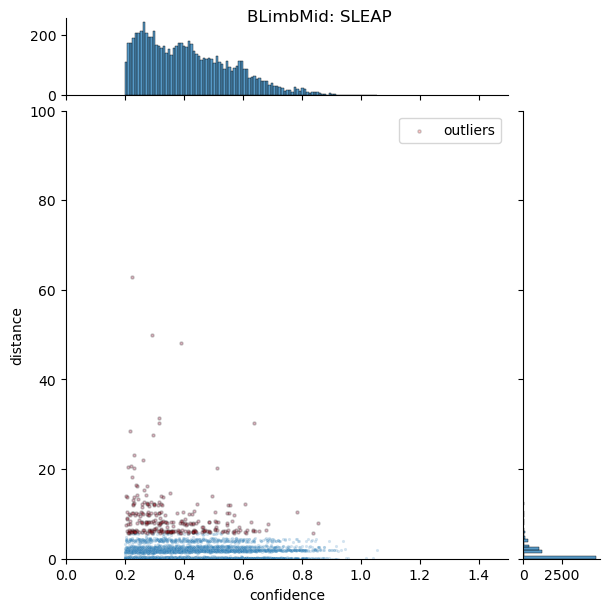

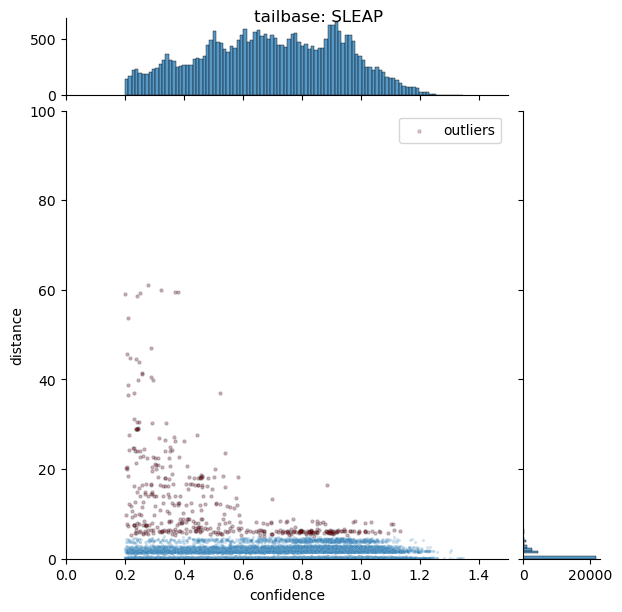

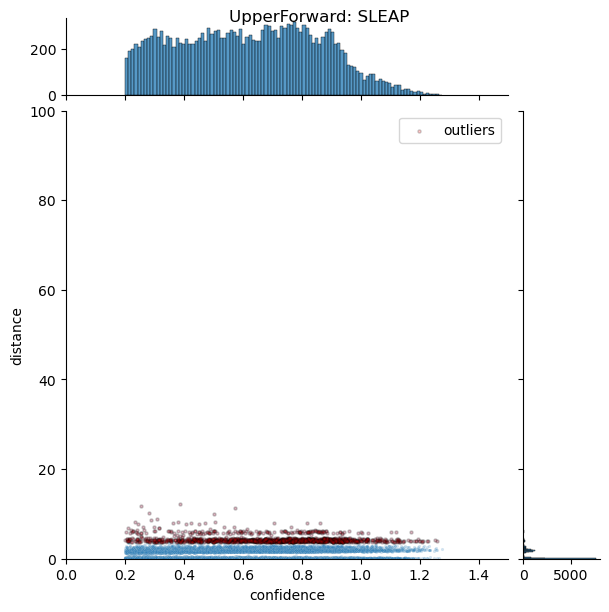

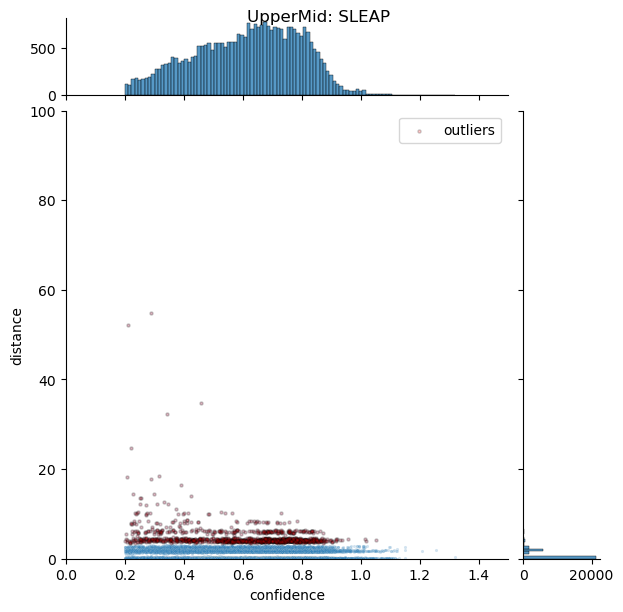

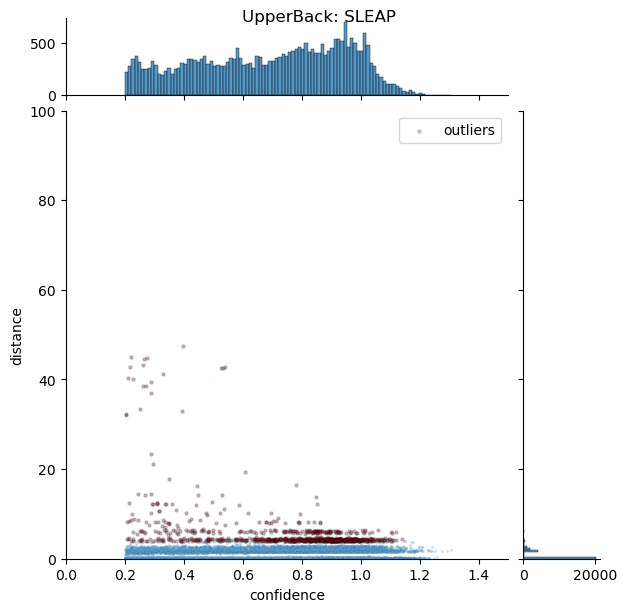

In [224]:
keypoints = ds_sleap.keypoints.values
for i in keypoints:
    x = ds_sleap.sel(space='x', keypoints=i, drop=True).to_array(dim='variable', name=None)
    y = ds_sleap.sel(space='y', keypoints=i, drop=True).to_array(dim='variable', name=None)
    np.array(ds_sleap.confidence.sel(keypoints=i)).squeeze()

    x = np.array(x).squeeze() #each array has value, confidence
    y = np.array(y).squeeze()

    x_c = x[0, :]
    y_c = y[0, :]
    distances = np.sqrt(np.diff(x_c)**2 + np.diff(y_c)**2)
    distances = np.insert(distances, 0, 0)

    confidence = np.array(ds_sleap.confidence.sel(keypoints=i)).squeeze()
    mask = ~np.isnan(distances) & ~np.isnan(confidence)
    confidence = confidence[mask]
    distances = distances[mask]


    dist_mean = np.mean(distances)
    dist_std = np.std(distances)
    outliers = distances > dist_mean + 2*dist_std

    g = sns.jointplot(x = confidence, y = distances, kind='scatter',
                       marginal_ticks=True, marginal_kws=dict(bins=100, fill=True), space=0.2,  alpha=0.2, s=5)
    g.ax_joint.scatter(x=confidence[outliers], y=distances[outliers], color='red', s=5, alpha=0.2, label='outliers', edgecolors='black')
    g.ax_joint.set_xlim(0, 1.5)
    g.ax_joint.set_ylim(0, 100)



    g.ax_joint.legend()
    # g.ax_marg_y.set_yscale('log')

    g.set_axis_labels('confidence', 'distance')
    g.figure.suptitle(f'{i}: SLEAP')


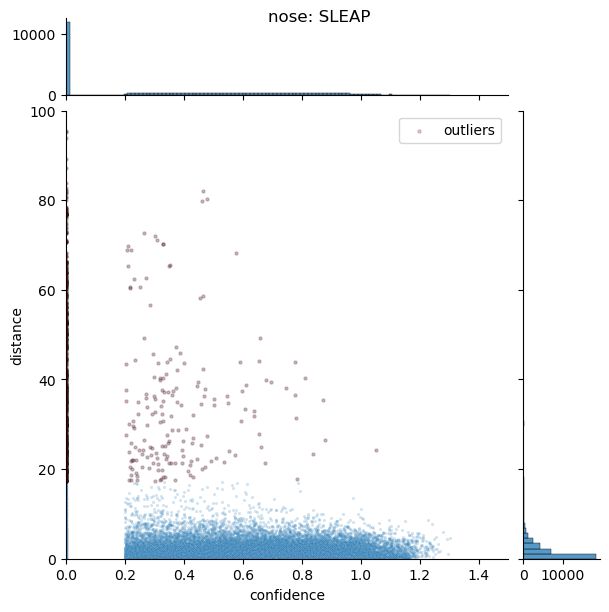

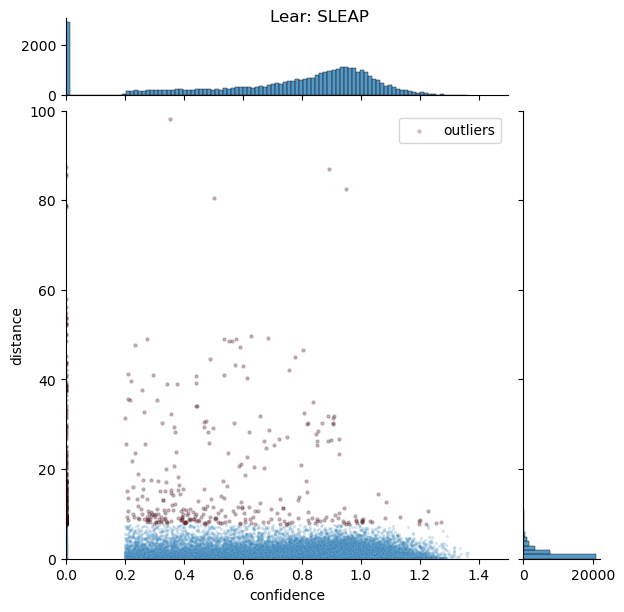

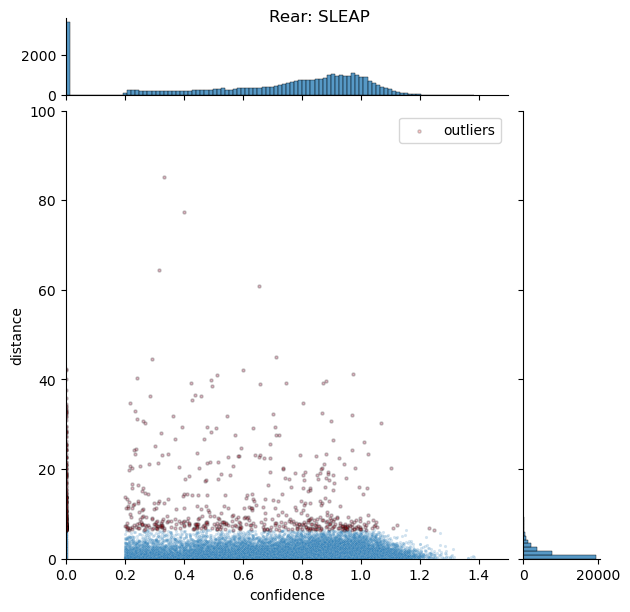

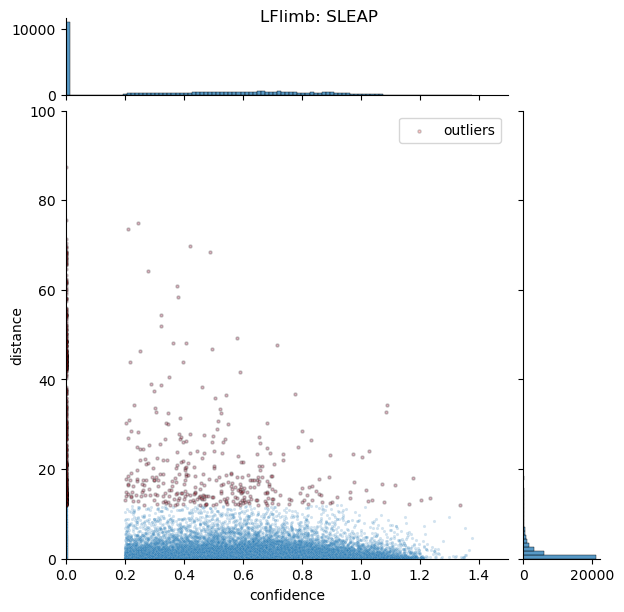

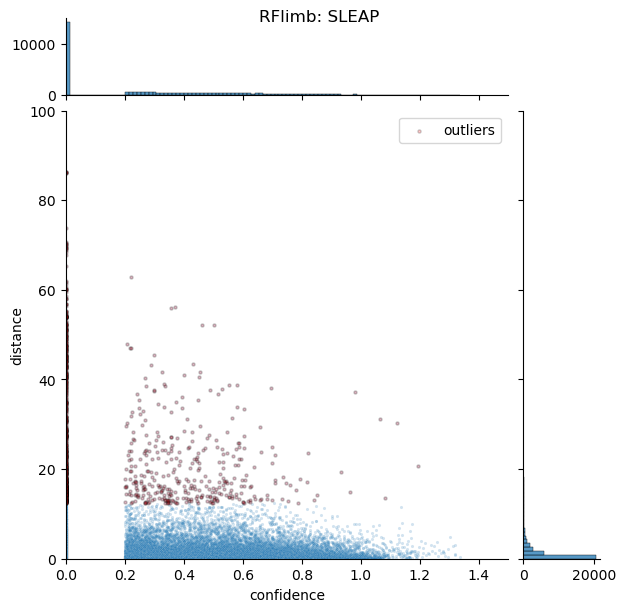

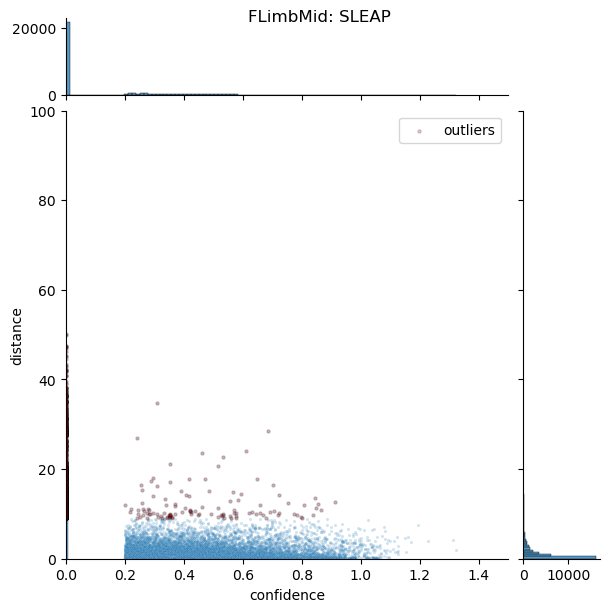

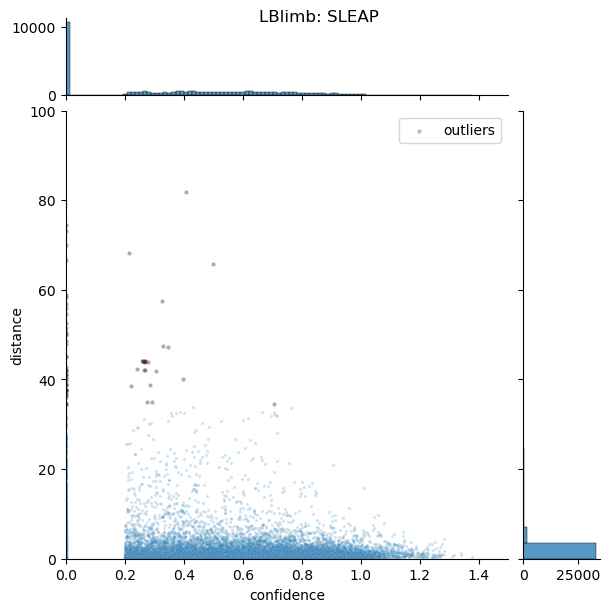

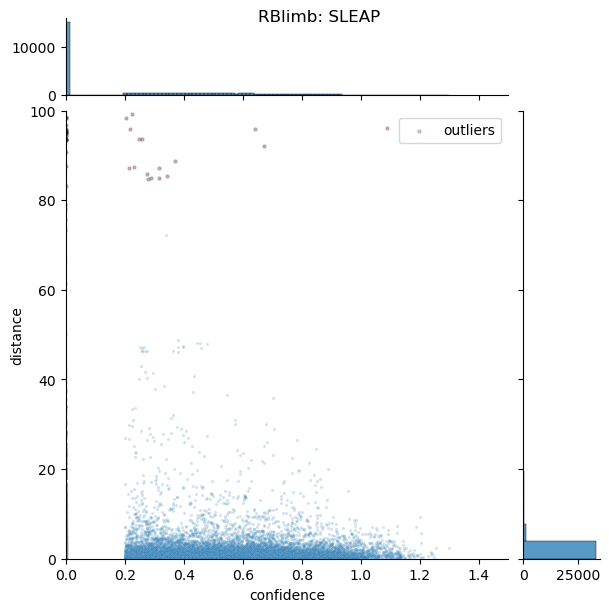

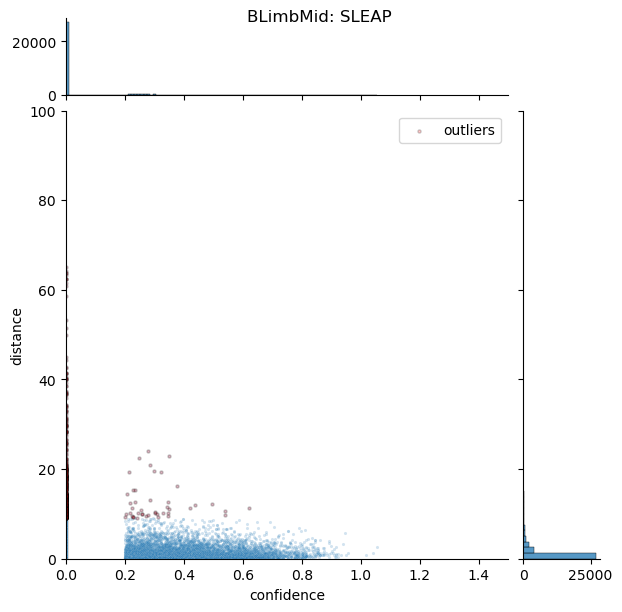

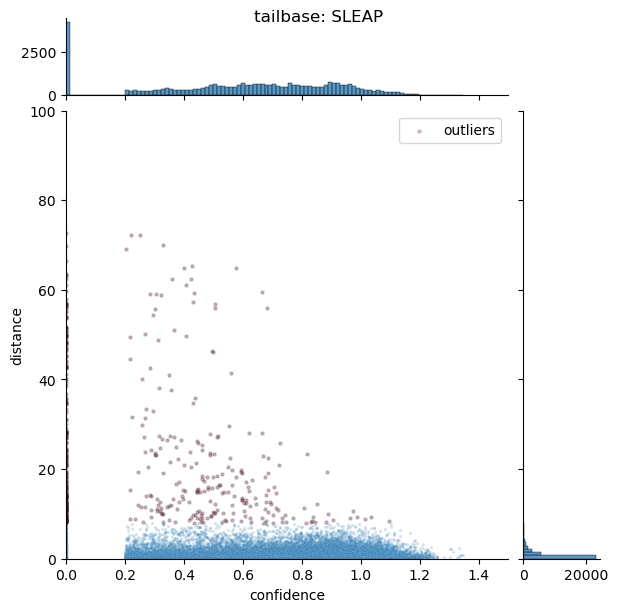

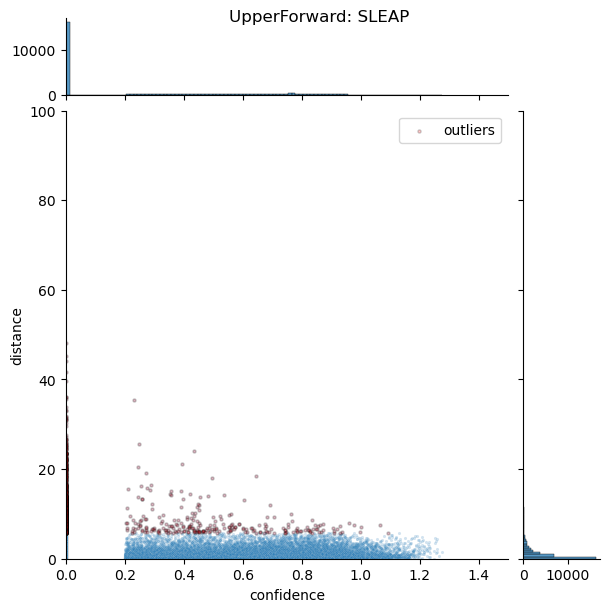

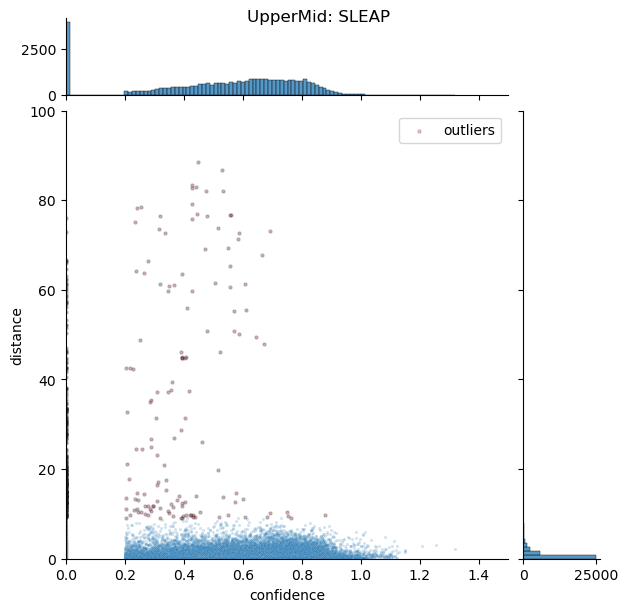

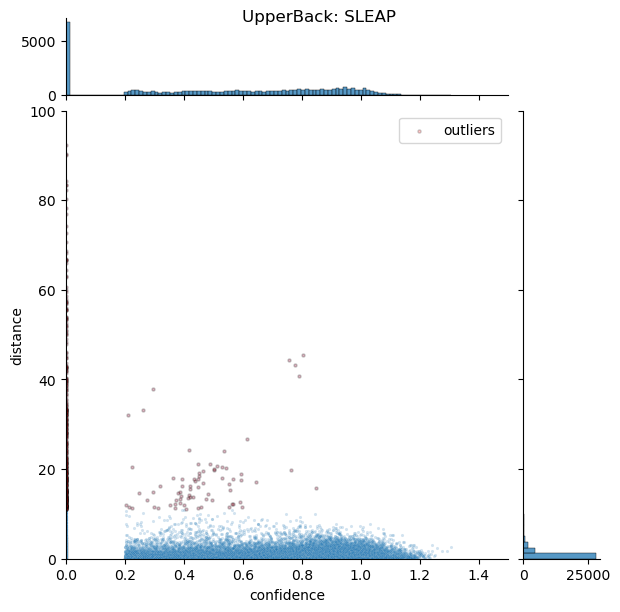

In [223]:
keypoints = ds_dlc.keypoints.values
for i in keypoints:
    x = ds_dlc.sel(space='x', keypoints=i, drop=True).to_array(dim='variable', name=None)
    y = ds_dlc.sel(space='y', keypoints=i, drop=True).to_array(dim='variable', name=None)
    np.array(ds_dlc.confidence.sel(keypoints=i)).squeeze()

    x = np.array(x).squeeze() #each array has value, confidence
    y = np.array(y).squeeze()

    x_c = x[0, :]
    y_c = y[0, :]
    distances = np.sqrt(np.diff(x_c)**2 + np.diff(y_c)**2)
    distances = np.insert(distances, 0, 0)

    confidence = np.array(ds_sleap.confidence.sel(keypoints=i)).squeeze()
    mask = ~np.isnan(distances) & ~np.isnan(confidence)
    confidence = confidence[mask]
    distances = distances[mask]


    dist_mean = np.mean(distances)
    dist_std = np.std(distances)
    outliers = distances > dist_mean + 2*dist_std

    g = sns.jointplot(x = confidence, y = distances, kind='scatter',
                       marginal_ticks=True, marginal_kws=dict(bins=100, fill=True), space=0.2,  alpha=0.2, s=5)
    g.ax_joint.scatter(x=confidence[outliers], y=distances[outliers], color='red', s=5, alpha=0.2, label='outliers', edgecolors='black')
    g.ax_joint.set_xlim(0, 1.5)
    g.ax_joint.set_ylim(0, 100)



    g.ax_joint.legend()
    # g.ax_marg_y.set_yscale('log')

    g.set_axis_labels('confidence', 'distance')
    g.figure.suptitle(f'{i}: SLEAP')
